# Librerías

In [12]:
from keras.layers import Input, Dense, Lambda, Concatenate, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.models import Model
from keras import backend as K
import keras

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import warnings
import random
import h5py
import cv2
import os

In [13]:
warnings.filterwarnings('ignore')

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()

# Lectura de datos
En esta sección se leen los datos extraidos de Kaggle (https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri). Los datos representan imagenes MRI de cerebros de distintos pacientes. Entre los datos se encuentran las siguientes categorías:
- Cerebro con tumor glioma
- Cerebro sin tumor
- Cerebro con tumor meningioma
- Cerebro con tumor pituitario

Al momento de la lectura de las imagenes, se estandarizan a 128x128 pixeles y se convierten a escalas de gris.

In [16]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [17]:
path = '/content/drive/MyDrive/Talleres MML/Proyecto/data/'

In [18]:
# Read data and reshape images to 128 x 128

X = []
y = []
image_size = 128
for i in labels:
    folderPath = os.path.join(path,'Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        X.append(img)
        y.append(i)

for i in labels:
    folderPath = os.path.join(path,'Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        X.append(img)
        y.append(i)

X = np.array(X)
y = np.array(y)

100%|██████████| 74/74 [00:20<00:00,  3.65it/s]


In [19]:
X_train, X_test, y_train ,y_test = train_test_split(X, y,
                                      test_size=0.1,random_state=101)

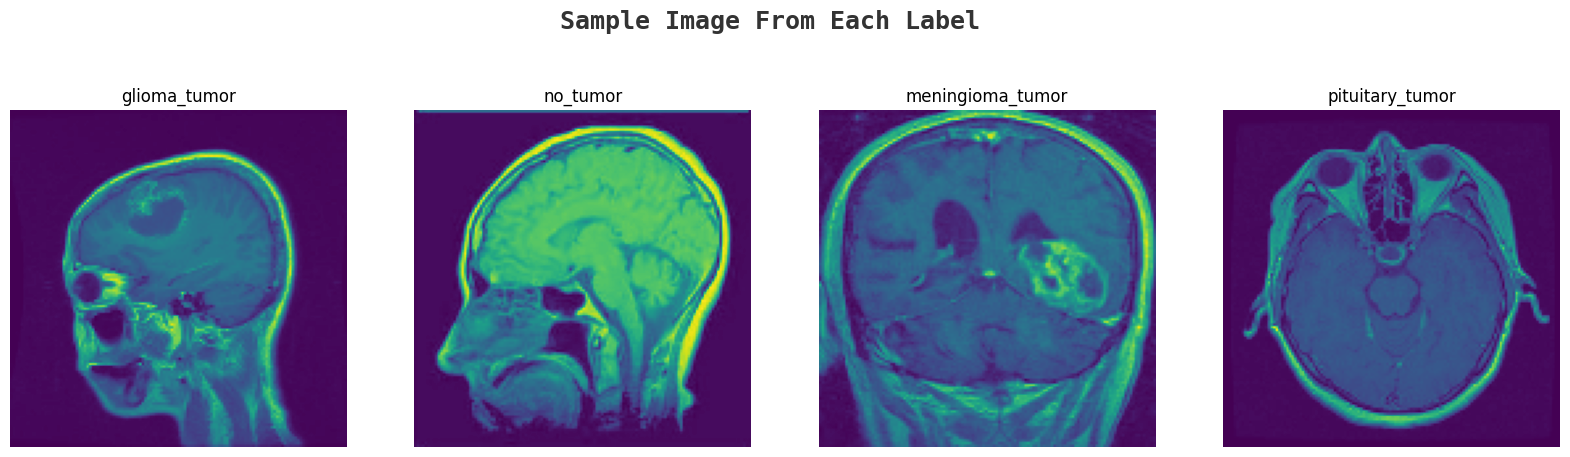

In [20]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color='black',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

# Procesamiento de datos
En esta sección se procesan los datos de entrada. Para las categorías de cada imagen, se vectorizan obteniendo vectores dummies. Para las imagenes en blanco y negro, se normalizan para tener únicamente valores entre 0 y 1.

In [21]:
# One hot encoder
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [22]:
X_train = X_train[:,:,:,np.newaxis]/255
X_test = X_test[:,:,:,np.newaxis]/255

In [23]:
X_train.shape, X_test.shape

((2937, 128, 128, 1), (327, 128, 128, 1))

In [24]:
y_train.shape, y_test.shape

((2937, 4), (327, 4))

In [ ]:
# with h5py.File(path + 'processed_data_128_20230726.h5', "w") as out:
#     out.create_dataset("X_train",X_train.shape, dtype='float32', data=X_train)
#     out.create_dataset("y_train", y_train.shape,dtype='float32', data=y_train)
#     out.create_dataset("X_test",X_test.shape, dtype='float32', data=X_test)
#     out.create_dataset("y_test", y_test.shape,dtype='float32', data=y_test)

# Modelo
Se define el modelo. Se utilizará una arquitectura de Conditional Convoltional Variational Autoencoder (CCVAE) que se divide en dos partes principales: encoder y decoder. El encoder es una red neuronal que recibe como entrada una imagen y un label (en este caso, el tipo de tumor), y retorna un vector de tamaño 512. El decoder, a su vez, recibe como entrada un vector de tamaño 512 junto con un label y retorna una imagen reconstruida.

## Hiperparámetros

In [25]:
batch_size = 64 # batch size
latent_dim = 512 # latent space size
optim = Adam(lr=0.001)
shape_img = X_train.shape[1:]
n_cat = y_train.shape[1]
n_epoch = 400

In [26]:
shape_img

(128, 128, 1)

## Encoder

In [27]:
enc_input_image = Input(shape=(shape_img), name="input_image")
enc_input_label = Input(shape=(n_cat), name="input_label")

# convolutionals block
conv1 = Conv2D(filters=32, kernel_size=3, activation="relu")(enc_input_image)
conv1 = Conv2D(filters=32, kernel_size=3, activation="relu")(conv1)
maxpooling1 = MaxPooling2D(pool_size = 2, strides =1, padding="valid")(conv1)
conv2 = Conv2D(filters=32, kernel_size=3, activation="relu")(maxpooling1)
conv2 = Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(conv2)
maxpooling2 = MaxPooling2D(pool_size = 2, strides =1, padding="valid")(conv2)
conv3 = Conv2D(filters=64, kernel_size=3, strides=2, activation='relu')(maxpooling2)
conv3 = Conv2D(filters=64, kernel_size=3, activation='relu')(conv3)
maxpooling3 = MaxPooling2D(pool_size = 2, strides =1, padding="valid")(conv3)

# concat
flattened = Flatten()(maxpooling3)
enc_concat = Concatenate()([flattened, enc_input_label])

encoder_hidden = Dense(1024, name="hidden_layer")(enc_concat)

mu = Dense(latent_dim, activation='linear', name="mu")(encoder_hidden)
l_sigma = Dense(latent_dim, activation='linear', name="l_sigma")(encoder_hidden)
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(latent_dim, ), mean=0., stddev=1.) # shape antes => (batch_size, latent_dim)
    return mu + K.exp(l_sigma / 2) * eps
z = Lambda(sample_z, output_shape = (latent_dim, ), name="latent_vector")([mu, l_sigma]) # output encoder

encoder = Model([enc_input_image, enc_input_label], z, name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  320         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 124, 124, 32  9248        ['conv2d[0][0]']                 
                                )                                                           

## Decoder

In [28]:
dec_inp_latent_vector = Input(shape=(latent_dim), name="input_latent_vector")
decoder_inp_label = Input(shape=(n_cat), name = "input_label")
dec_concat = Concatenate(name="decoder_concat")([dec_inp_latent_vector, decoder_inp_label])

decoder_hidden = Dense(1024, activation="relu", name="hidden_layer")(dec_concat)
decoder_hidden = Dense(32*32*32, activation="relu", name="hidden_layer2")(decoder_hidden)
reshaped = Reshape(target_shape=(32,32,32))(decoder_hidden)

# convolutionals block
dec_conv1 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation="relu", padding='same')(reshaped)
dec_conv1 = Conv2DTranspose(filters=64, kernel_size=3, activation="relu", padding='same')(dec_conv1)
dec_conv2 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation="relu", padding='same')(dec_conv1)
dec_conv2 = Conv2DTranspose(filters=32, kernel_size=3,  activation="relu", padding='same')(dec_conv2)
dec_conv3 = Conv2DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(dec_conv2)
dec_conv3 = Conv2DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(dec_conv3)


dec_output_img = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')(dec_conv3)
dec_output_img = Flatten()(dec_output_img)
decoder = Model([dec_inp_latent_vector, decoder_inp_label], dec_output_img, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_latent_vector (InputLaye  [(None, 512)]       0           []                               
 r)                                                                                               
                                                                                                  
 input_label (InputLayer)       [(None, 4)]          0           []                               
                                                                                                  
 decoder_concat (Concatenate)   (None, 516)          0           ['input_latent_vector[0][0]',    
                                                                  'input_label[0][0]']            
                                                                                            

## Conditional Convolutional Variational autoencoder

In [29]:
latent_vector = encoder(inputs=[enc_input_image, enc_input_label]) # z
output_img = decoder(inputs=[latent_vector, enc_input_label])
CVAE = Model(inputs=[enc_input_image, enc_input_label], outputs=output_img, name="CVAE")
CVAE.summary()

Model: "CVAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_label (InputLayer)       [(None, 4)]          0           []                               
                                                                                                  
 encoder (Functional)           (None, 512)          45440544    ['input_image[0][0]',            
                                                                  'input_label[0][0]']            
                                                                                               

## Entrenamiento
Para el entrenamiento se tomaron en cuenta dos funciones de pérdida:
- **KL-loss**: compara las distribuciones de la imagen real con la imagen recostruida. Se basa en la divergencia de Kullback-Leibler.
- **Recon-Loss**: Compara las diferencias entre los valores de pixeles de la imagen real con la recontruida.

In [30]:
def vae_loss(y_true, y_pred):
    print(y_true.shape, y_pred.shape)
    recon = recon_loss(y_true, y_pred)
    kl = KL_loss(y_true, y_pred)
    return recon + kl

def KL_loss(y_true, y_pred):
     # importante se usan las capas de mu y sigma del encoder
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [31]:
CVAE.compile(optimizer=optim, loss=vae_loss, metrics=[KL_loss, recon_loss])

(?, ?) (?, 16384)


In [32]:
im_train = X_train.reshape(X_train.shape[0], -1)
im_test = X_test.reshape(X_test.shape[0], -1)
print(im_train.shape)

(2937, 16384)


In [33]:
checkpoint_filepath = path + 'Models/20230725_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                save_weights_only=True,
                                monitor='val_loss',
                                mode='min',
                                save_best_only=True)

In [ ]:
cvae_hist = CVAE.fit([X_train, y_train], im_train, verbose = 1, batch_size=batch_size, epochs=n_epoch,
                     validation_data = ([X_test, y_test], im_test),
                     callbacks = [EarlyStopping(patience = 100), model_checkpoint_callback])

Train on 2937 samples, validate on 327 samples
Epoch 1/400
2937/2937 [==============================] - 40s 14ms/sample - loss: 9014.3815 - KL_loss: 369.1601 - recon_loss: 8645.2227 - val_loss: 7092.3643 - val_KL_loss: 1.3886 - val_recon_loss: 7090.9761
Epoch 2/400
2937/2937 [==============================] - 15s 5ms/sample - loss: 7184.2383 - KL_loss: 12.5326 - recon_loss: 7171.7061 - val_loss: 6978.7818 - val_KL_loss: 3.3980 - val_recon_loss: 6975.3838
Epoch 3/400
2937/2937 [==============================] - 15s 5ms/sample - loss: 7057.4538 - KL_loss: 11.1194 - recon_loss: 7046.3345 - val_loss: 6876.7074 - val_KL_loss: 7.5669 - val_recon_loss: 6869.1406
Epoch 4/400
2937/2937 [==============================] - 15s 5ms/sample - loss: 7048.6012 - KL_loss: 11.7627 - recon_loss: 7036.8389 - val_loss: 6715.0786 - val_KL_loss: 17.4659 - val_recon_loss: 6697.6123
Epoch 5/400
2937/2937 [==============================] - 15s 5ms/sample - loss: 6916.9278 - KL_loss: 16.9336 - recon_loss: 6899.99

## Reconstrucción

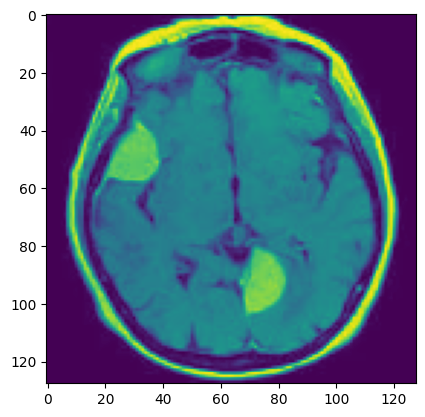

In [ ]:
plt.imshow(X_train[10]) # 10

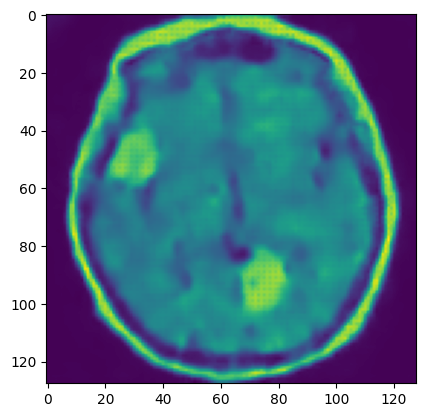

In [ ]:
plt.imshow(CVAE.predict([[X_train[10]], [y_train[10]]]).reshape(128, 128))

In [ ]:
decoder.predict([np.array([[0]*512]), np.array([[1,0,0,0]])])

array([[ 1.9401358e-03, -5.3097494e-05,  1.9856635e-04, ...,
        -5.5566337e-04, -7.5303391e-04,  6.9326069e-04]], dtype=float32)

# Guardar modelo
Si ya se tienen guardados los pesos, se puede correr la segunda celda sin necesidad de entrenar el modelo previamente.

In [ ]:
# CVAE.save_weights(path + "Models/CVAE_26_07.h5")
# encoder.save_weights(path + "Models/encoder_26_07.h5")
# decoder.save_weights(path + "Models/decoder_26_07.h5")

In [34]:
CVAE.load_weights(path + "Models/CVAE_26_07.h5")
encoder.load_weights(path + "Models/encoder_26_07.h5")
decoder.load_weights(path + "Models/decoder_26_07.h5")

# Representación
En esta sección se mostrará la parte "variacional" del modelo. La idea al no tener un autoencoder tradicional es que, al tomar distintos valores de vector latente, se puedan obtener de igual forma imagenes que parezcan reales. Para poder evaluar esto, se parte de una imagen real (base) y se agrega un ruido a su vector latente. Se puede observar cómo poco a poco se va alejando la imagen de la original.

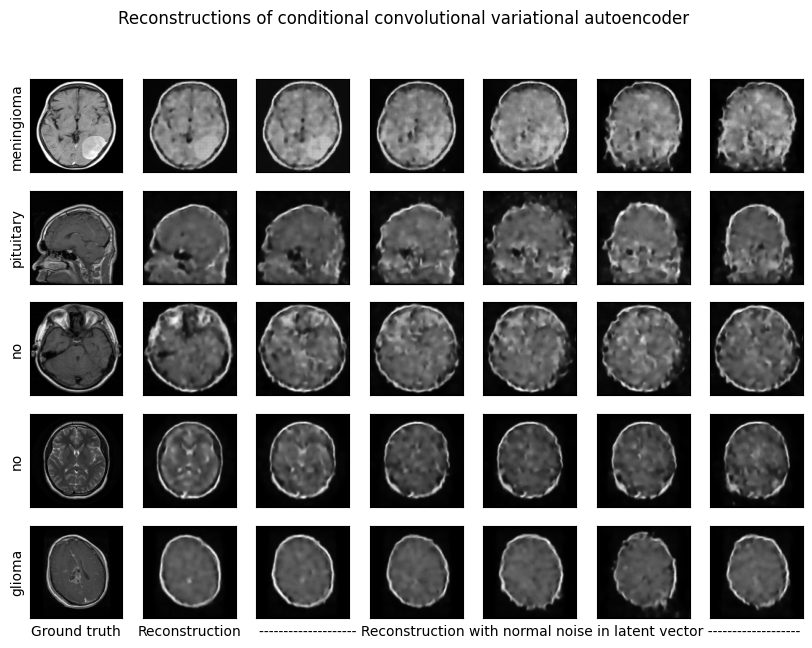

In [ ]:
fig, axes = plt.subplots(ncols = 7, nrows = 5, figsize = (10,7), sharex = True, sharey = True)
fig.suptitle('Reconstructions of conditional convolutional variational autoencoder')


recon = []
for i in range(5):
  n = random.randint(0, X_train.shape[0])
  recon.append(n)

  z = encoder.predict([[X_train[n]], label])
  label = [y_train[n]]

  axes[i][0].set_ylabel(labels[np.argmax(label)].split('_')[0])
  axes[i][0].imshow( X_train[n], cmap = 'gray')
  axes[i][0].set_xticks([])
  axes[i][0].set_yticks([])

  for j in range(1,7):
    axes[i][j].imshow( decoder.predict([z, np.array(label)]).reshape((128,128)), cmap = 'gray')
    axes[i][j].set_xticks([])
    axes[i][j].set_yticks([])
    noise = np.random.normal(loc=0.0, scale=1.0, size=512)
    z = z+noise

axes[4][0].set_xlabel('Ground truth')
axes[4][1].set_xlabel('Reconstruction')
axes[4][4].set_xlabel('-------------------- Reconstruction with normal noise in latent vector -------------------')

plt.savefig('Reconstructions.png')

# Sacar datos para clasificación
En esta y las siguientes secciones se analizará el rendimiento de un modelo de clasificación entrenado con las imagenes reconstruidas.

In [35]:
X_reconst_test = CVAE.predict([X_test, y_test])

In [36]:
X_reconst_train = CVAE.predict([X_train, y_train])

In [ ]:
# with h5py.File(path + 'Models/reconstructions_26072023.h5', "w") as out:
#     out.create_dataset("X_reconst_train",X_reconst_train.shape, dtype='float32', data=X_reconst_train)
#     out.create_dataset("y_train", y_train.shape,dtype='float32', data=y_train)
#     out.create_dataset("X_reconst_test",X_reconst_test.shape, dtype='float32', data=X_reconst_test)
#     out.create_dataset("y_test", y_test.shape,dtype='float32', data=y_test)

In [37]:
X_reconst_train = [cv2.cvtColor(im.reshape((128,128)),cv2.COLOR_GRAY2RGB) for im in X_reconst_train]
X_reconst_test = [cv2.cvtColor(im.reshape((128,128)),cv2.COLOR_GRAY2RGB) for im in X_reconst_test]

X_reconst_train = np.array(X_reconst_train)
X_reconst_test = np.array(X_reconst_test)

# Clasificación - imagenes reconstruidas

In [38]:
# Transfer Learning

effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size, 3))

Instructions for updating:
Colocations handled automatically by placer.


16705208/16705208 [==============================] - 0s 0us/step


In [39]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [40]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_reconst_train, y_train, validation_split=0.1, epochs =12, verbose=1, batch_size=32,)
#                   callbacks=[tensorboard,checkpoint,reduce_lr])

Train on 2643 samples, validate on 294 samples
Epoch 1/12
2643/2643 [==============================] - 275s 104ms/sample - loss: 0.7111 - acc: 0.7317 - val_loss: 1.9241 - val_acc: 0.1497
Epoch 2/12
2643/2643 [==============================] - 262s 99ms/sample - loss: 0.3972 - acc: 0.8487 - val_loss: 1.6576 - val_acc: 0.1497
Epoch 3/12
2643/2643 [==============================] - 264s 100ms/sample - loss: 0.2419 - acc: 0.9073 - val_loss: 1.6856 - val_acc: 0.2517
Epoch 4/12
2643/2643 [==============================] - 262s 99ms/sample - loss: 0.2065 - acc: 0.9296 - val_loss: 3.0911 - val_acc: 0.1497
Epoch 5/12
2643/2643 [==============================] - 271s 103ms/sample - loss: 0.1301 - acc: 0.9542 - val_loss: 1.6238 - val_acc: 0.2925
Epoch 6/12
2643/2643 [==============================] - 264s 100ms/sample - loss: 0.1504 - acc: 0.9504 - val_loss: 2.9461 - val_acc: 0.1497
Epoch 7/12
2643/2643 [==============================] - 268s 101ms/sample - loss: 0.1071 - acc: 0.9652 - val_loss: 

In [ ]:
y_pred_train = model.predict(X_reconst_train)
y_pred_test = model.predict(np.array(X_reconst_test))

In [ ]:
y_pred_train = np.argmax(y_pred_train, axis = 1)
y_pred_test = np.argmax(y_pred_test, axis = 1)